In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
import seaborn as sns
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
%run ../src/models/geo_helpers.py
%run ../src/models/section_series.py
%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
city_locations_path = '../data/external/' +\
    'worldcitiespop.txt'

city_locations = pd.read_csv(city_locations_path, encoding = "ISO-8859-1").rename(columns={'City': 'city'})
city_locations = city_locations[city_locations['Population'] > 0] # filter for populated cities
print('Shape: {}'.format(city_locations.shape))
city_locations.head()

KeyboardInterrupt: 

In [49]:
earthquake_locations_path = '../data/external/' +\
    'earthquakes_affected_locations/earthquakes_affected_locations.csv'

earthquake_locations = pd.read_csv(earthquake_locations_path, encoding = "ISO-8859-1").drop('country', axis=1)
earthquake_locations['city'] = earthquake_locations['city'].apply(lambda c: c.lower())
print('Shape: {}'.format(earthquake_locations.shape))
earthquake_locations.head()

Shape: (2719, 12)


,id,city,latitude,longitude,geoname,year,month,day,Totaldeaths,Totalaffected,Totaldamage000US,insured_losses
0,1,takhar,36.7000,69.8000,NaN,1992,5,20,14,0,0,0
1,2,jowzan,36.7500,66.0000,Jowzjan,1994,5,1,160,100330,0,0
2,2,mazar-i-sharif,36.7500,67.0000,mazar-i-sharif,1994,5,1,160,100330,0,0
3,2,balkh,36.7501,66.8997,balkh,1994,5,1,160,100330,0,0
4,2,termez,37.2242,67.2783,NaN,1994,5,1,160,100330,0,0


In [51]:
[e for e in earthquake_locations['city'] if 'port' in e]

['portoviejo',
 'portoviejo',
 'portoviejo',
 'port-au-prince',
 'port glaud',
 'port portal',
 'port vila city']

In [2]:
%run ../src/models/section_series.py
annual_frames = {}
for year in range(1993, 2014):
    print('Loading data for year {}'.format(year))
    try:
        annual_frames[year] = pd.read_csv('../data/processed/section_series_returns_small/{}.csv'.format(year)).set_index('city')
    except FileNotFoundError:
        earthquake_locations_in_year = earthquake_locations[earthquake_locations.year == year]
        earthquake_cities_in_year = earthquake_locations_in_year['city'].unique()
        annual_frames[year] = pd.merge(city_locations, earthquake_locations_in_year, on='city', how='left')
        annual_frames[year] = annual_frames[year].fillna(0).reset_index().groupby('city').agg({
            'Totaldeaths': 'sum',
            'Totalaffected': 'sum',
            'Totaldamage000US': 'sum',
            'insured_losses': 'sum',
            'Latitude': 'first',
            'Longitude': 'first',
            'city': 'first'
        }).set_index('city').rename(columns={
            'Latitude': 'latitude',
            'Longitude': 'longitude',
            'Totaldeaths': 'total_deaths',
            'Totalaffected': 'total_affected',
            'Totaldamage000US': 'total_damage_usd'
        })
        annual_frames[year]['year'] = year
        annual_frames[year]['earthquake_dummy'] = annual_frames[year].index.map(lambda c: c in earthquake_cities_in_year)
        series_loader = SectionSeriesLoader(
            img_shape=(200, 200),
            start_year=year,
            end_year=year,
            SRC_PATH='../data/interim/Version_4_DMSP-OLS_Nighttime_Lights_Time_Returns/*.npz')
        target_coords_list = [{'lat': r[0],'lng': r[1]} for r
            in annual_frames[year][['latitude', 'longitude']].values]
        annual_frames[year]['mean_luminosity_return'] = series_loader.load_multiple_means(target_coords_list).reshape(-1)
        annual_frames[year].to_csv('../data/processed/section_series_returns_small/{}.csv'.format(year))
        
    print(annual_frames[year].shape)
    
panel = xr.Dataset.from_dataframe(pd.concat(annual_frames))
del annual_frames

Loading data for year 1993
(43183, 9)
Loading data for year 1994
(43183, 9)
Loading data for year 1995
(43183, 9)
Loading data for year 1996
(43183, 9)
Loading data for year 1997
(43183, 9)
Loading data for year 1998
(43183, 9)
Loading data for year 1999
(43183, 9)
Loading data for year 2000
(43183, 9)
Loading data for year 2001
(43183, 9)
Loading data for year 2002
(43183, 9)
Loading data for year 2003
(43183, 9)
Loading data for year 2004
(43183, 9)
Loading data for year 2005
(43183, 9)
Loading data for year 2006
(43183, 9)
Loading data for year 2007
(43183, 9)
Loading data for year 2008
(43183, 9)
Loading data for year 2009
(43183, 9)
Loading data for year 2010
(43183, 9)
Loading data for year 2011
(43183, 9)
Loading data for year 2012
(43183, 9)
Loading data for year 2013
(43183, 9)


In [55]:
panel

<xarray.Dataset>
Dimensions:                 (city: 43183, level_0: 21)
Coordinates:
  * level_0                 (level_0) int64 1993 1994 1995 1996 1997 1998 ...
  * city                    (city) object '0' 'a' 'a coruna' ...
Data variables:
    insured_losses          (level_0, city) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    total_affected          (level_0, city) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    longitude               (level_0, city) float64 100.7 10.22 -8.407 ...
    latitude                (level_0, city) float64 18.79 63.97 43.37 39.15 ...
    total_damage_usd        (level_0, city) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    total_deaths            (level_0, city) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    year                    (level_0, city) int64 1993 1993 1993 1993 1993 ...
    earthquake_dummy        (level_0, city) bool False False False False ...
    mean_luminosity_return  (level_0, city) float64 -0.1373 0.6671 -0.4299 ...

In [4]:
%%time
try:
    data = pd.read_csv('../data/processed/section_series_returns_small/all.csv').set_index('city')
except FileNotFoundError:
    feature_cols = ['latitude', 'longitude', 'mean_luminosity_return', 'total_affected', 'total_damage_usd', 'insured_losses',
                    'total_deaths', 'earthquake_dummy']
    data = pd.melt(
        panel.to_dataframe()[feature_cols].reset_index(),
        id_vars=['city','level_0'],
        value_vars=feature_cols)\
        .rename(columns={'level_0': 'year'})
    data = data\
        .set_index(data[['year','variable']].astype(str).apply(lambda r: '_'.join(r), axis=1))\
        .drop(['year','variable'], axis=1)
    data = data.groupby(['city']).apply(lambda g: g.transpose().loc['value',:])
    data.to_csv('../data/processed/section_series_returns_small/all.csv')

data.head()

CPU times: user 1.58 s, sys: 140 ms, total: 1.72 s
Wall time: 1.74 s


In [5]:
targets = data[['2013_mean_luminosity_return']].fillna(0)
features = data.drop(['2013_mean_luminosity_return'], axis=1)

In [35]:
def cross_validate(features, targets, params, n_splits=2):
    k_fold = KFold(n_splits=n_splits, shuffle=True, random_state=23)
    param_names = list(params.keys())
    result = pd.DataFrame(columns=['mse','wmse','mae','wmae','r2','wr2','ev','wev'] + param_names)
    for train, test in k_fold.split(features, targets):
        test_data = xgb.DMatrix(data=features.iloc[test].values,
                                 label=targets.iloc[test].values,
                                 feature_names=features.columns)
        train_data = xgb.DMatrix(data=features.iloc[train].values,
                                 label=targets.iloc[train].values,
                                 feature_names=features.columns)
        linear_tree_booster = xgb.train(
            params={
                'booster': 'gbtree',
                'objective': 'reg:linear',
                **params
            },
            dtrain=train_data,
            num_boost_round=25
        )
        pred = np.nan_to_num(linear_tree_booster.predict(test_data))
        result = result.append(pd.DataFrame({
            'mse': mean_squared_error(test_data.get_label(), pred),
            'wmse': mean_squared_error(test_data.get_label(), pred, sample_weight=test_data.get_label()),
            'mae': mean_absolute_error(test_data.get_label(), pred),
            'wmae': mean_absolute_error(test_data.get_label(), pred, sample_weight=test_data.get_label()),
            'r2': r2_score(test_data.get_label(), pred),
            'wr2': r2_score(test_data.get_label(), pred, sample_weight=test_data.get_label()),
            'ev': explained_variance_score(test_data.get_label(), pred),
            'wev': explained_variance_score(test_data.get_label(), pred, sample_weight=test_data.get_label()),
            **params
        }, index=[str(params)])) 
        
    return result.mean()


param_grid = {
    'n_estimators': [100],
    'eta': [.001],
    'alpha': [.99],
    'booster': ['gblinear']
}
param_list = [dict(zip(param_grid, v)) for v in it.product(*param_grid.values())]
try:
    cv_results
except NameError:
    cv_results = pd.DataFrame(columns=['mse','wmse','mae','wmae','r2','wr2','ev','wev'] + list(param_grid.keys()))
    
for params in param_list:
    cv_results = cv_results.append(cross_validate(features, targets, params), ignore_index=True)
    
cv_results.sort_values('mse')

,mse,wmse,mae,wmae,r2,wr2,ev,wev,booster,max_depth,n_estimators,eta,alpha
23,0.9649,3.5868,0.7016,1.3668,-0.0073,6.1397,-0.0034,-0.0074,nan,nan,100.0000,0.0001,nan
31,1.2992,3.2793,0.6968,1.2892,-0.3573,5.6990,-0.3495,0.0006,nan,nan,100.0000,0.0005,0.8000
30,1.3023,3.2816,0.6968,1.2893,-0.3606,5.7022,-0.3527,0.0034,nan,nan,100.0000,0.0005,0.4000
27,1.3036,3.2828,0.6968,1.2894,-0.3619,5.7040,-0.3541,0.0049,nan,nan,100.0000,0.0005,0.2000
28,1.3036,3.2828,0.6968,1.2894,-0.3620,5.7039,-0.3541,0.0049,nan,nan,100.0000,0.0005,0.2000
29,1.3038,3.2828,0.6968,1.2894,-0.3621,5.7039,-0.3543,0.0049,nan,nan,100.0000,0.0005,0.2000
26,1.3046,3.2835,0.6968,1.2894,-0.3630,5.7048,-0.3551,0.0056,nan,nan,100.0000,0.0005,0.1000
25,1.3046,3.2835,0.6968,1.2894,-0.3630,5.7049,-0.3551,0.0056,nan,nan,100.0000,0.0005,0.1000
24,1.3055,3.2841,0.6969,1.2894,-0.3639,5.7057,-0.3561,0.0064,nan,nan,100.0000,0.0005,nan
33,2.4471,3.0314,0.6910,1.2130,-1.5590,5.3436,-1.5468,0.0881,nan,nan,100.0000,0.0010,0.9900


In [16]:
cv_results.sort_values('wmse')

,mse,wmse,mae,wmae,r2,wr2,ev,wev,booster,max_depth,n_estimators,eta,alpha
16,907.7375,29.1583,0.5677,0.5290,-949.2331,43.2259,-949.2071,42.4190,nan,nan,100.0000,0.0500,0.3000
19,931.3003,29.3697,0.5684,0.5272,-973.9009,43.5499,-973.8739,42.7467,nan,nan,100.0000,0.0500,0.9000
18,927.6760,29.5285,0.5687,0.5284,-970.1061,43.7707,-970.0791,42.9651,nan,nan,100.0000,0.0500,0.7000
17,927.0405,29.8618,0.5694,0.5297,-969.4396,44.2418,-969.4129,43.4331,nan,nan,100.0000,0.0500,0.5000
1,"1,915.8211",58.2610,0.5997,0.4832,"-2,004.5198",85.4716,"-2,004.4490",84.8644,nan,-10.0000,100.0000,0.1000,nan
3,"1,945.9832",60.1596,0.6038,0.4884,"-2,036.0910",88.1903,"-2,036.0192",87.5738,nan,nan,100.0000,0.1000,0.3000
9,"1,955.3079",60.4170,0.6044,0.4885,"-2,045.8525",88.5644,"-2,045.7805",87.9473,nan,nan,100.0000,0.1000,0.3000
15,"1,971.1470",60.6867,0.6051,0.4876,"-2,062.4338",88.9627,"-2,062.3611",88.3479,nan,nan,100.0000,0.1000,0.9000
13,"1,954.3410",60.8987,0.6054,0.4903,"-2,044.8387",89.2450,"-2,044.7671",88.6250,nan,nan,100.0000,0.1000,0.7000
5,"1,958.4603",61.5317,0.6067,0.4919,"-2,049.1495",90.1452,"-2,049.0774",89.5224,nan,nan,100.0000,0.1000,0.5000


In [36]:
train_data = xgb.DMatrix(data=features[::2].values,
                         label=targets[::2].values,
                         feature_names=features.columns)
test_data = xgb.DMatrix(data=features[1::2].values,
                        label=targets[1::2].values,
                        feature_names=features.columns)
linear_tree_booster = xgb.train(
    params={
        'booster': 'gblinear',
        'objective': 'reg:linear',
        'eta': 0.001
    },
    dtrain=train_data,
    num_boost_round=25
)
pred = np.nan_to_num(linear_tree_booster.predict(test_data))
result = pd.DataFrame({
    'mse': mean_squared_error(test_data.get_label(), pred),
    'wmse': mean_squared_error(test_data.get_label(), pred, sample_weight=test_data.get_label()),
    'mae': mean_absolute_error(test_data.get_label(), pred),
    'wmae': mean_absolute_error(test_data.get_label(), pred, sample_weight=test_data.get_label()),
    'r2': r2_score(test_data.get_label(), pred),
    'wr2': r2_score(test_data.get_label(), pred, sample_weight=test_data.get_label()),
    'ev': explained_variance_score(test_data.get_label(), pred),
    'wev': explained_variance_score(test_data.get_label(), pred, sample_weight=test_data.get_label()),
}, index=['w'])

result

,ev,mae,mse,r2,wev,wmae,wmse,wr2
w,0.1060,0.6837,0.8643,0.0899,-0.0376,1.1750,2.7764,4.2949


In [37]:
pred = linear_tree_booster.predict(test_data)
test_ae = test_data.get_label() - pred
test_wae = (test_data.get_label() - pred) * test_data.get_label()
test_mse = mean_squared_error(test_data.get_label(), pred)
true_mean = test_data.get_label().mean()

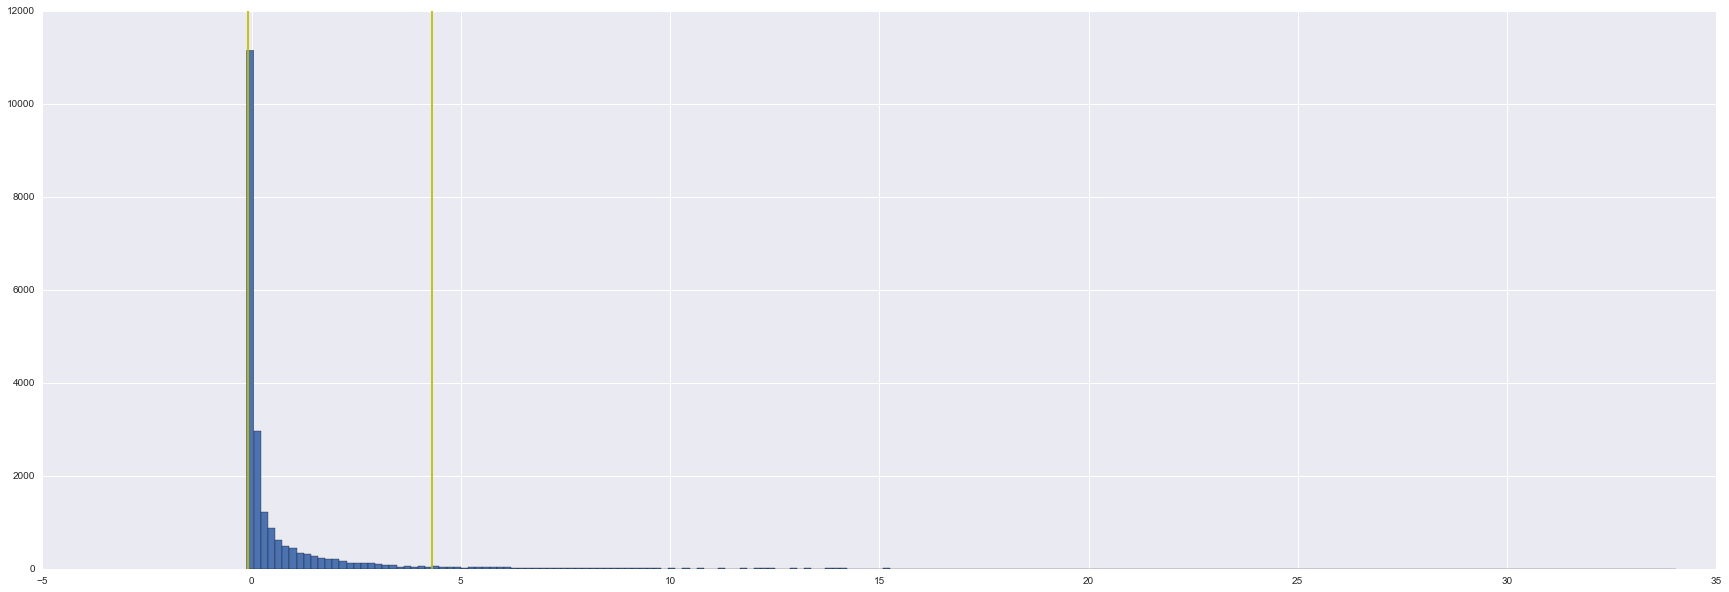

In [38]:
plt.figure(figsize=(30,10))
plt.hist(test_wae, bins=200)
plt.axvline(x=np.percentile(test_wae, 95), c='y')
plt.axvline(x=np.percentile(test_wae, 5), c='y')
plt.show()

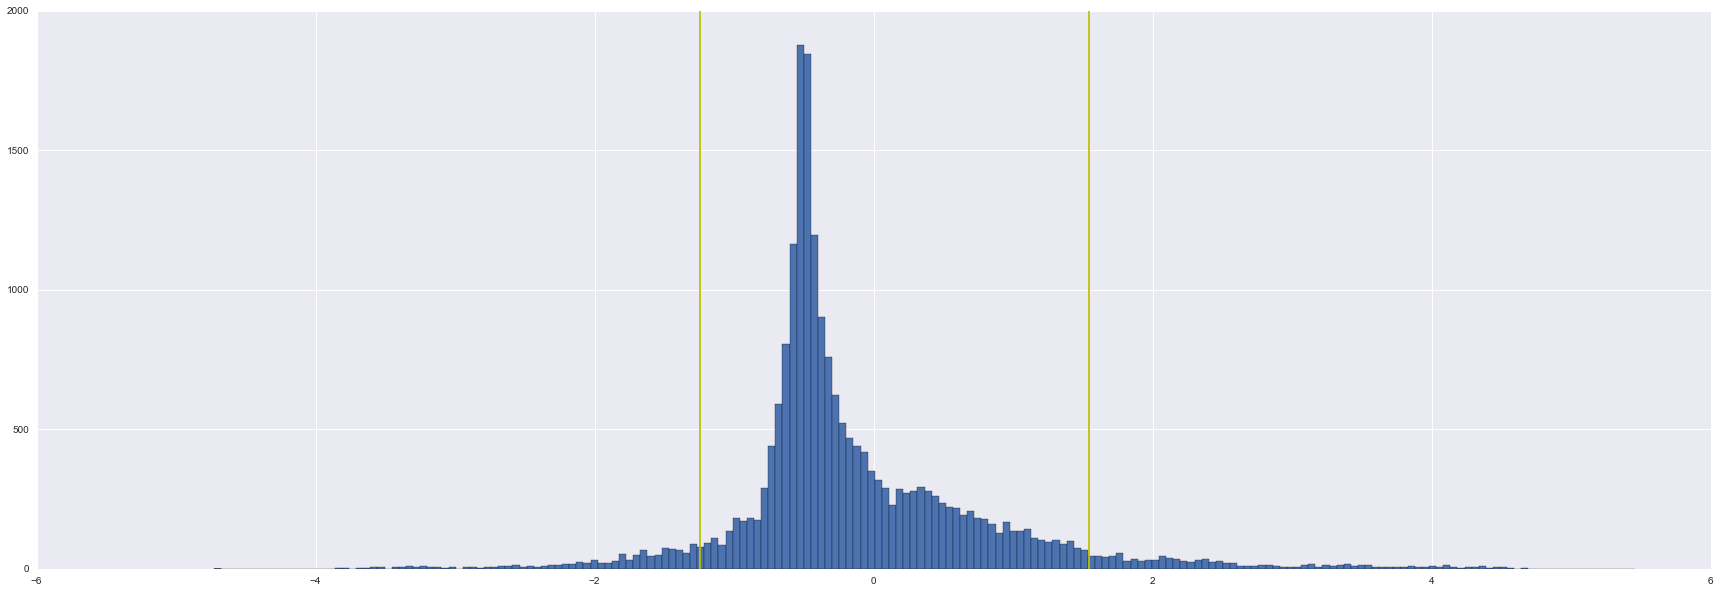

In [41]:
plt.figure(figsize=(30,10))
plt.hist(test_ae, bins=200)
plt.axvline(x=np.percentile(test_ae, 95), c='y')
plt.axvline(x=np.percentile(test_ae, 5), c='y')
plt.show()

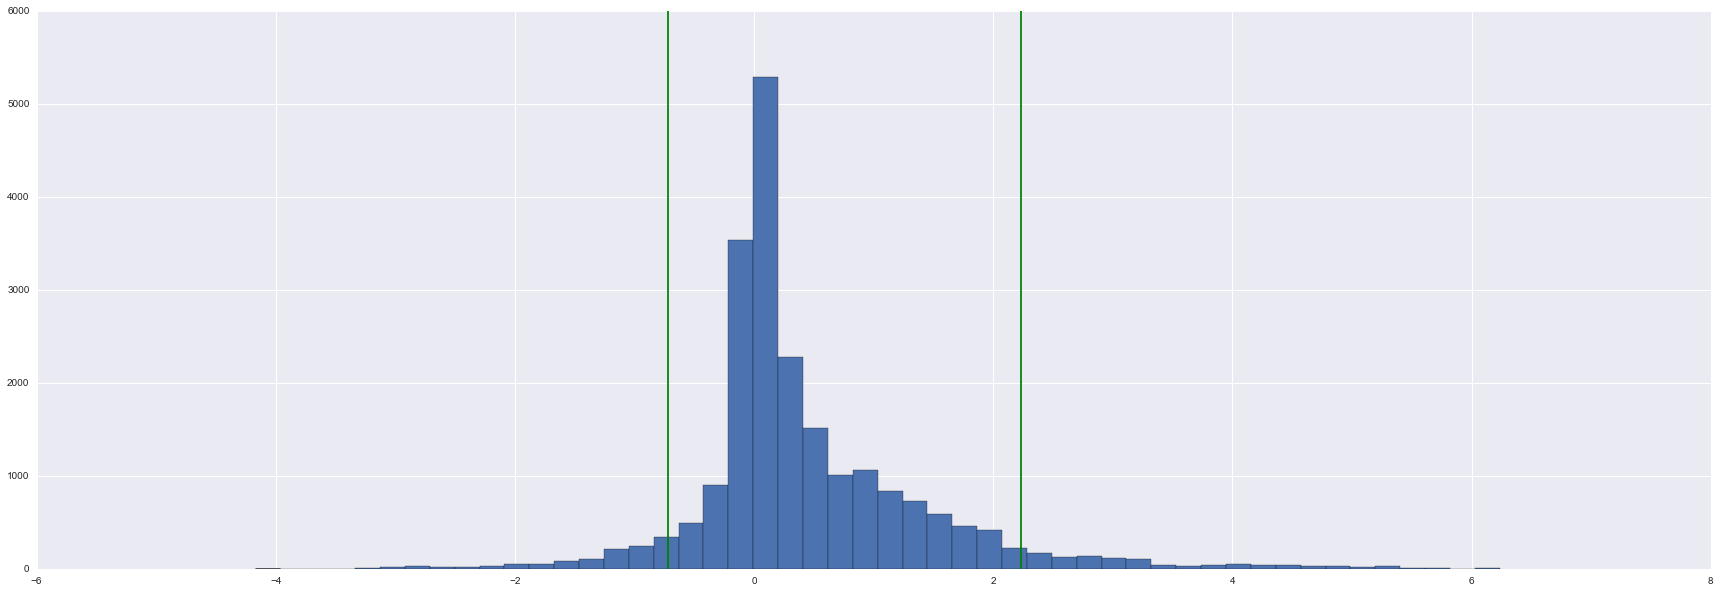

In [42]:
plt.figure(figsize=(30,10))
plt.hist(test_data.get_label(), bins=50)
plt.axvline(x=np.percentile(test_data.get_label(), 95), c='g')
plt.axvline(x=np.percentile(test_data.get_label(), 5), c='g')
plt.show()

In [46]:
help(linear_tree_booster)

Help on Booster in module xgboost.core object:

class Booster(builtins.object)
 |  "A Booster of of XGBoost.
 |  
 |  Booster is the model of xgboost, that contains low level routines for
 |  training, prediction and evaluation.
 |  
 |  Methods defined here:
 |  
 |  __copy__(self)
 |  
 |  __deepcopy__(self, _)
 |  
 |  __del__(self)
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, params=None, cache=(), model_file=None)
 |      Initialize the Booster.
 |      
 |      Parameters
 |      ----------
 |      params : dict
 |          Parameters for boosters.
 |      cache : list
 |          List of cache items.
 |      model_file : string
 |          Path to the model file.
 |  
 |  __setstate__(self, state)
 |  
 |  attr(self, key)
 |      Get attribute string from the Booster.
 |      
 |      Parameters
 |      ----------
 |      key : str
 |          The key to get attribute from.
 |      
 |      Returns
 |      -------
 |      value : str
 |          The attribute value of the

ValueError: Booster.get_score() results in empty

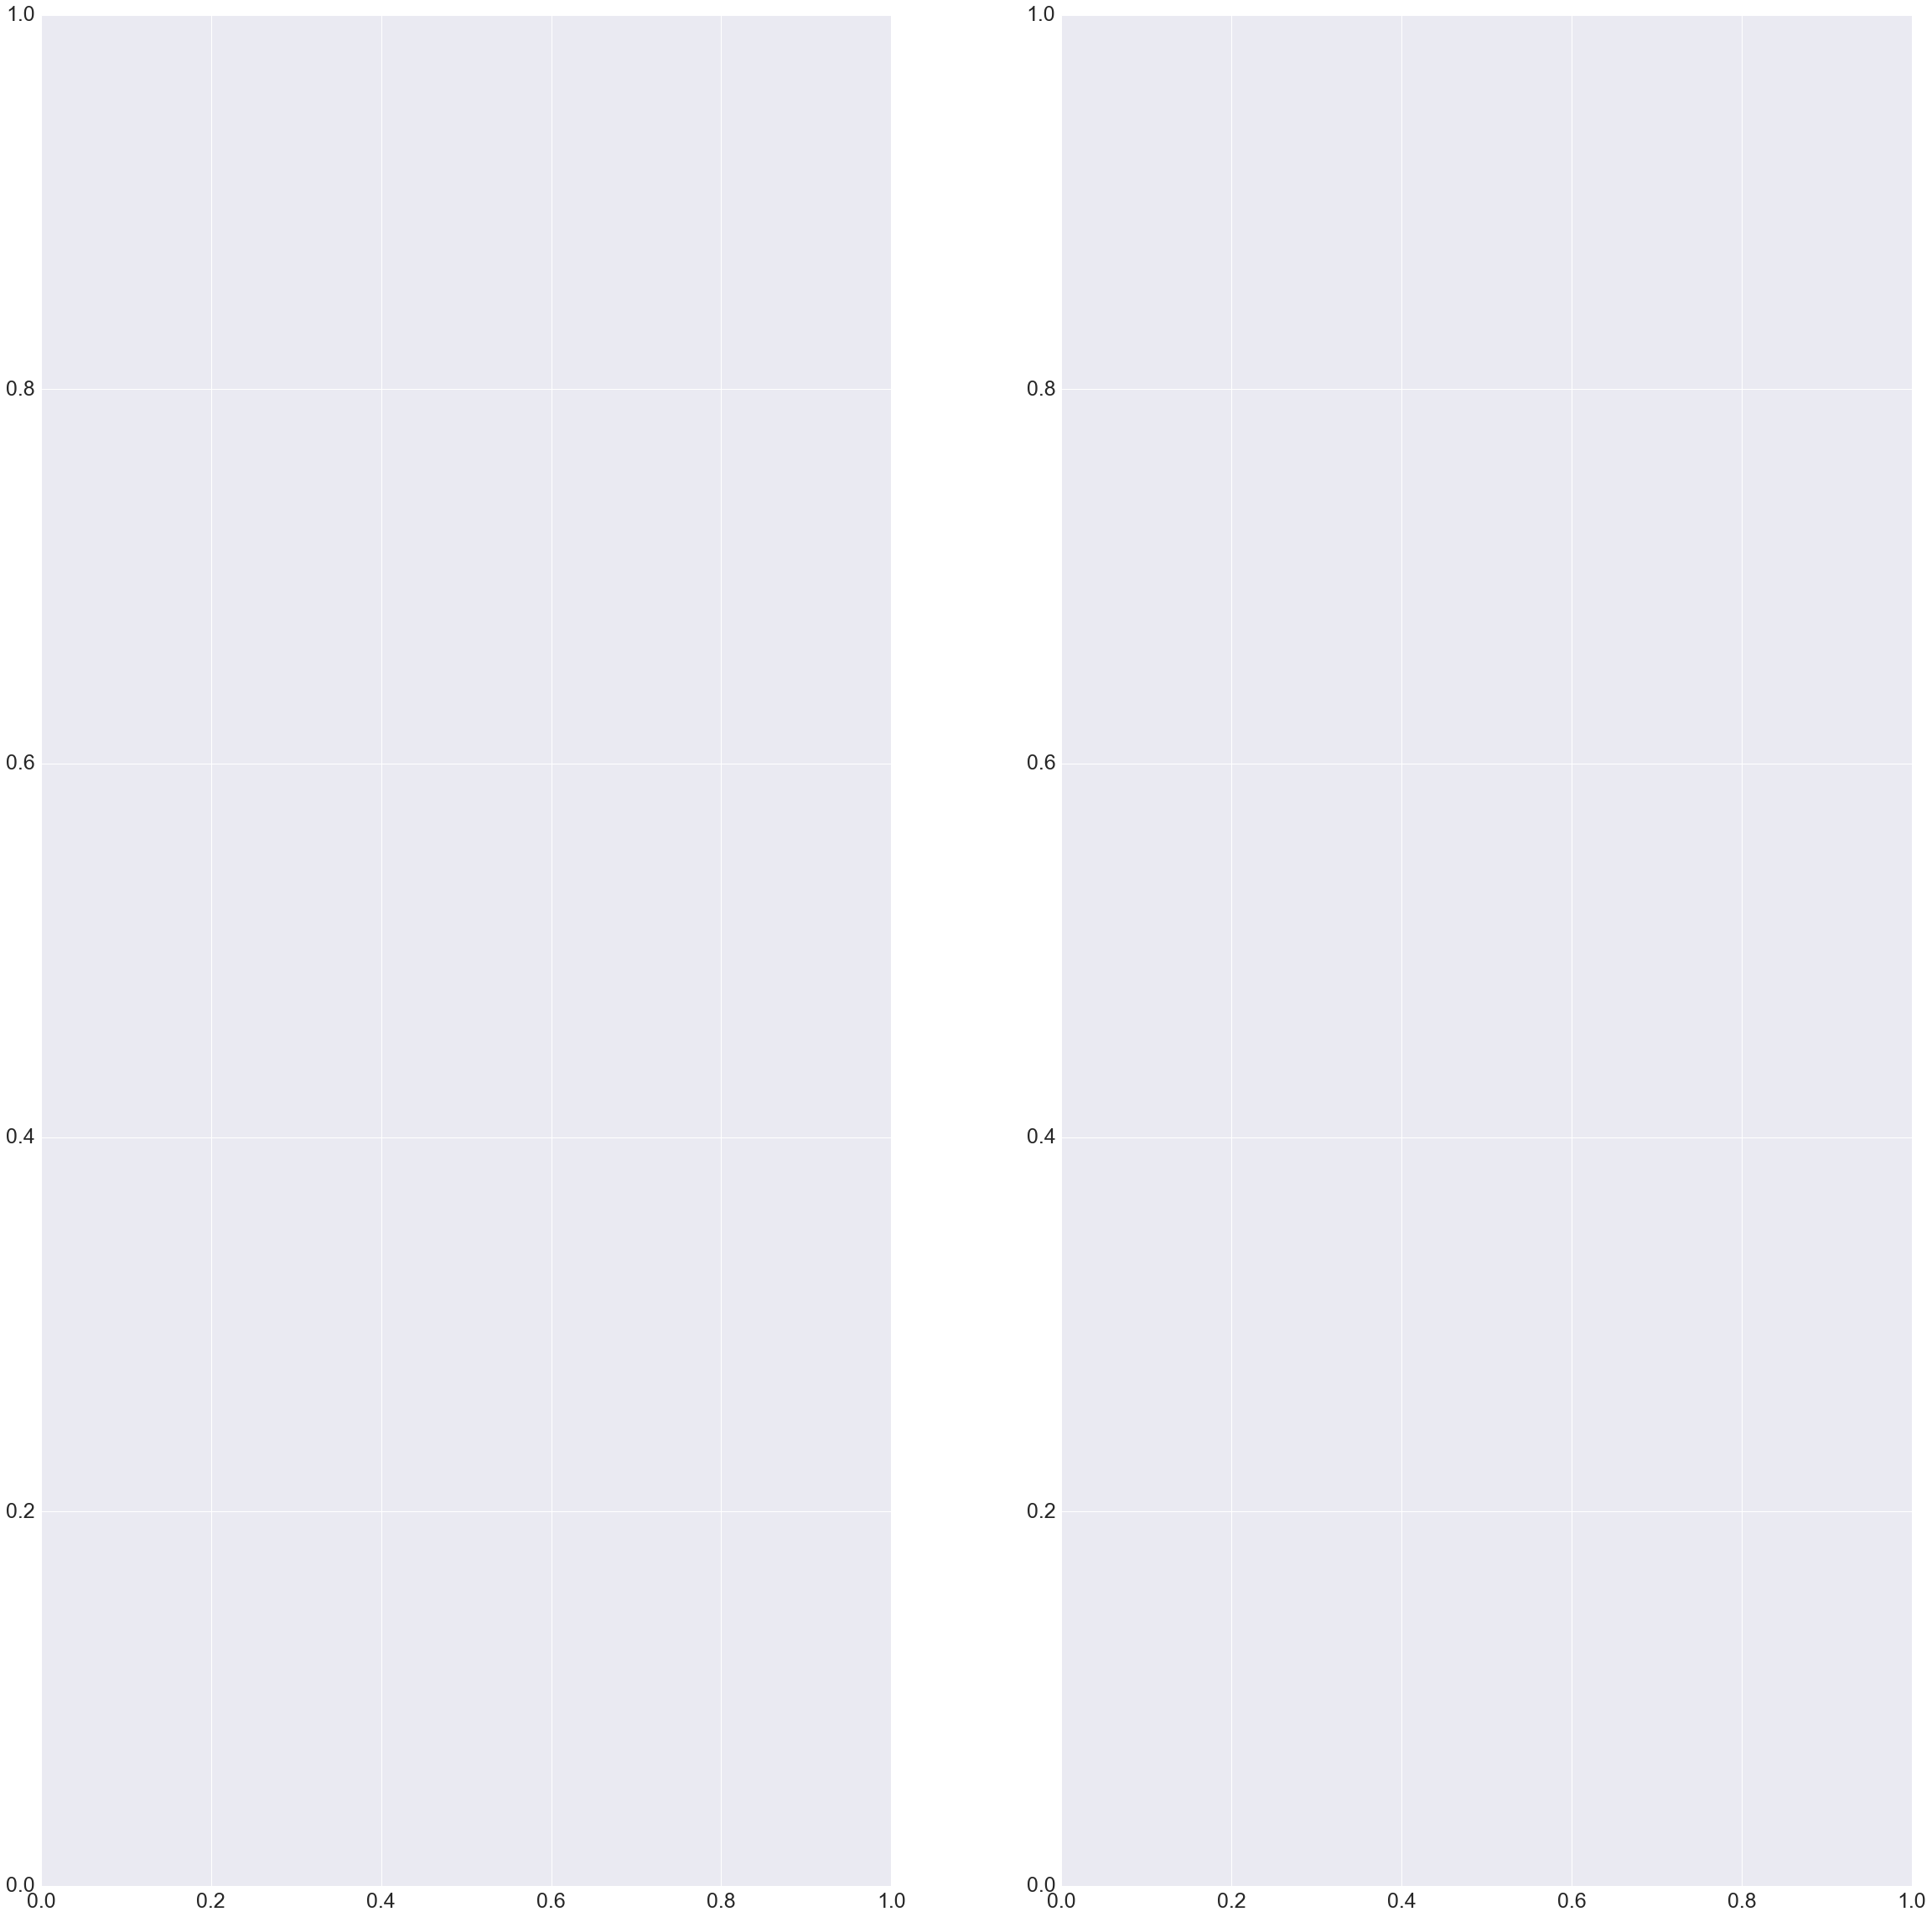

In [44]:
mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25) 
fig, axs = plt.subplots(1,2,figsize=(40,40))
xgb.plot_importance(linear_tree_booster, height=.4, importance_type='weight', ax=axs[1])
plt.show()

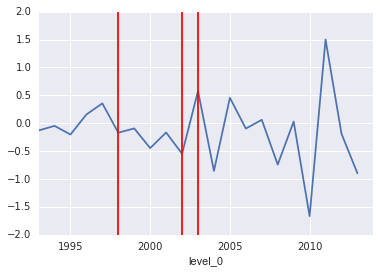

In [316]:
df = panel.sel(city='takhar').to_dataframe()
df['mean_luminosity_return'].plot()
for i, row in df[df['earthquake_dummy'] == True].iterrows():
    plt.axvline(x=row.year, c='r')

In [406]:
city_df = panel.sel(city='takhar')\
    .to_dataframe()[['latitude',
                     'longitude',
                     'mean_luminosity_return',
                     'total_affected',
                     'total_damage_usd',
                     'insured_losses',
                     'total_deaths',
                     'earthquake_dummy']].reset_index()
feature = city_df[(city_df.level_0 <= 2012) & (city_df.level_0 > 1994)].drop('level_0', axis=1).values.reshape(-1)
target = city_df[city_df.level_0 == 2013]['mean_luminosity_return'].mean()
# print('True: {}, Predicted: {}'.format(target,linear_tree_booster.predict(xgb.DMatrix(feature.reshape(1,-1)))))

In [409]:
city_df

,level_0,latitude,longitude,mean_luminosity_return,total_affected,total_damage_usd,insured_losses,total_deaths,earthquake_dummy
0,1993,47.56,124.22,-0.13,0.00,0.00,0.00,0.00,False
1,1994,47.56,124.22,-0.05,0.00,0.00,0.00,0.00,False
2,1995,47.56,124.22,-0.20,0.00,0.00,0.00,0.00,False
3,1996,47.56,124.22,0.16,0.00,0.00,0.00,0.00,False
4,1997,47.56,124.22,0.36,0.00,0.00,0.00,0.00,False
5,1998,47.56,124.22,-0.17,"32,818.00","10,000.00",0.00,"2,323.00",True
6,1999,47.56,124.22,-0.09,0.00,0.00,0.00,0.00,False
7,2000,47.56,124.22,-0.45,0.00,0.00,0.00,0.00,False
8,2001,47.56,124.22,-0.17,0.00,0.00,0.00,0.00,False
9,2002,47.56,124.22,-0.55,"3,513.00",0.00,0.00,150.00,True
